In [964]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pprint import pprint

import mod_models as mm
import mod_evolution as me
import mod_visualization as mv
import mod_stimulation as ms
from mod_models import logger
import inputools.Trajectory as it
from tools.utils import clf

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Settings

In [437]:
N = 4
Nj = 9

## Inputs

In [12]:
layer = it.InputLayer(N=9, kind='hd', sigma=0.01)
logger.info(layer)

2023-11-29 19:21:58 | InputLayer(N=9, kind=hd, sigma=0.01)


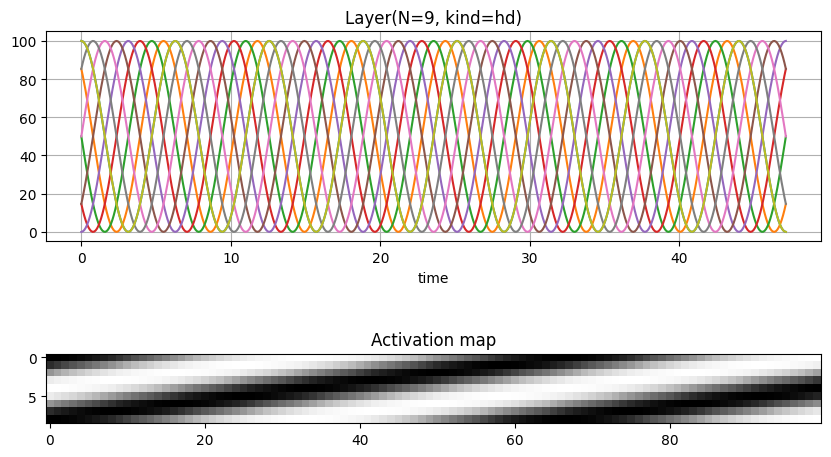

In [905]:
layer = it.HDLayer(N=9, sigma=1)
layer.plot(Tmax=15*np.pi, size=500)

2023-11-30 04:02:19 | Layer(N=9, kind=place)


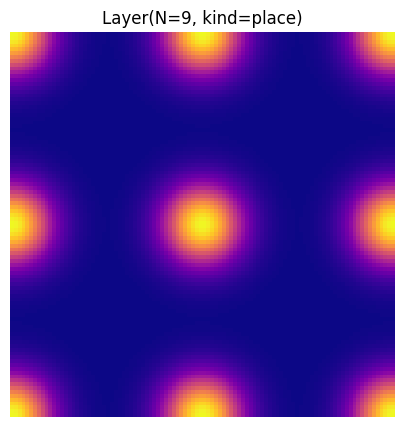

In [911]:
layer = it.PlaceLayer(N=9, sigma=0.01)
logger.info(layer)

layer.plot(kind=None, size=200,
          sigmoid_beta=0.3, sigmoid_alpha=0.5)

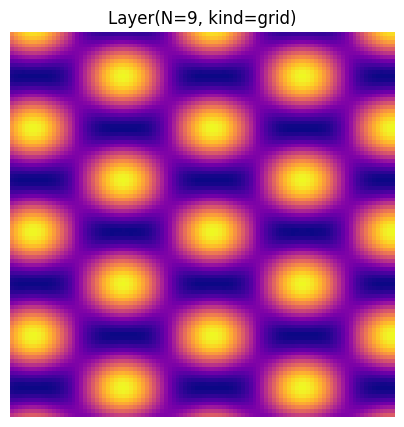

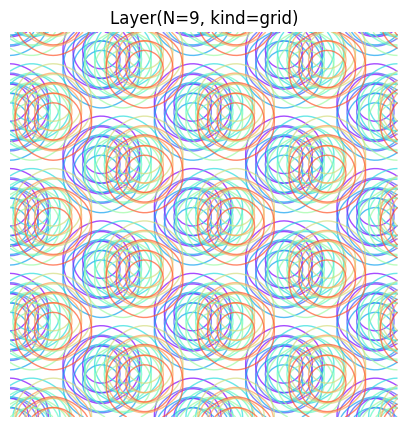

In [913]:
layer = it.GridLayer(N=9, sigma=6., 
                     scale=np.array([1.47, 0.52]))
layer.plot(size=200, kind=None, 
           sigmoid_beta=1, sigmoid_alpha=0.)
layer.plot(size=200, kind='contour')

## Simulation I

#### Models

In [5]:
model = mm.RateNetwork3(N=N, Nj=Nj, 
                       gain=4,
                       bias=2,
                       lr=1,
                       lr_beta=1.,
                       rule='hebb',
                       wff_std=0.01,
                       wff_min=0.01,
                       wff_max=3.,
                       wff_const=7,
                       wff_tau=10,
                       loc_magnitude=2)
logger.info(model)

2023-11-29 18:18:10 | RateNetwork3(N=4, Nj=6, rule=hebb) [oyfjj]


###### Load model from evolution

In [3]:
genome = me.load_best_individual()
genome

2023-11-24 15:02:47 | Available files in /Users/daniekru/Research/lab/PCNN/cache:
2023-11-24 15:02:47 | 0: best_2239_r3.json
2023-11-24 15:02:47 | 1: best_2220_r3.json
2023-11-24 15:02:47 | 2: best_2311_1657_r3.json
2023-11-24 15:02:47 | 3: best_2238_r3.json
2023-11-24 15:02:47 | 4: best_2233_r3.json
2023-11-24 15:02:47 | 5: best_2215_r3.json
2023-11-24 15:02:47 | 6: best_ind_2238.json
2023-11-24 15:02:47 | 7: best_2342_r3.json
2023-11-24 15:02:47 | 8: best_ind_2311.json
2023-11-24 15:02:47 | 9: top_ij_1.json
2023-11-24 15:02:47 | 10: best_2227_r3.json
2023-11-24 15:02:47 | 11: best_2218_r3.json
2023-11-24 15:02:47 | 12: best_2149_r3.json
2023-11-24 15:02:47 | 13: best_2226_r3.json
2023-11-24 15:02:47 | 14: best_2132_r3.json
2023-11-24 15:02:47 | 15: best_2311_1731_r3.json
2023-11-24 15:02:47 | 16: best_2411_1502_r3.json
2023-11-24 15:02:47 | 17: best_2129_r3.json
2023-11-24 15:02:47 | 18: best_2224_r3.json
2023-11-24 15:02:47 | 19: best_2213_r3.json


Choose a file:  16


2023-11-24 15:02:59 | Best individual loaded from best_2411_1502_r3.json in /Users/daniekru/Research/lab/PCNN/cache.


{'gain': 15.8,
 'bias': 1.0,
 'lr': 0.65999,
 'tau': 50.0,
 'wff_std': 0.001,
 'wff_min': 0.0,
 'wff_max': 3.0,
 'wff_tau': 132,
 'rule': 'hebb',
 'std_tuning': 0.001,
 'soft_beta': 0.1,
 'dt': 0.053,
 'N': 6,
 'Nj': 6}

In [4]:
model = mm.RateNetwork2(**genome)
logger.info(model)

2023-11-24 15:03:30 | RateNetwork2(N=6, Nj=6, rule=hebb)


#### Training

KeyboardInterrupt: 

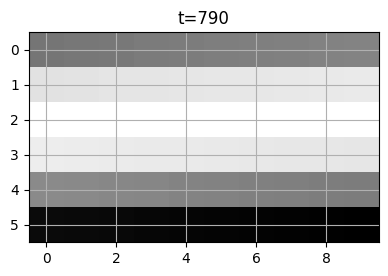

In [7]:
model.reset()


record = np.zeros((4, len(X)))
X2 = np.zeros((len(X) + 10, Nj))

for t, x in enumerate(X):
    
    model.step(x=x.reshape(-1, 1))
    record[0, t] = (model.Wff @ x.reshape(-1, 1))[0]
    record[1, t] = (model.Wff @ x.reshape(-1, 1))[1]
    record[2, t] = model.u[0]
    record[3, t] = model.u[1]
    X2[10:t+10] = X[:t]


    if t % 10 == 0:
        
        clf()
        plt.figure(figsize=(15, 6))
        plt.tight_layout()
        
        plt.subplot(221)
        plt.imshow(X2.T[:, t-10:t], cmap="Greys")
        #plt.ylim((0, 1))
        plt.title(f"{t=}")
        #plt.xlabel("time")
        plt.grid()
        
        plt.subplot(222)
        plt.axvline(0, color='black', alpha=0.3)
        plt.plot(np.flip(model.Wff[0], axis=0), range(Nj), '-b', alpha=0.4)
        plt.plot(np.flip(model.Wff[0], axis=0), range(Nj), 'ob', alpha=0.4)
        plt.plot(np.flip(model.Wff[1], axis=0), range(Nj), '-r', alpha=0.4)
        plt.plot(np.flip(model.Wff[1], axis=0), range(Nj), 'or', alpha=0.4)
        plt.title(f"Weights")
        plt.yticks(())
        plt.xlim((-5, 7))
        #plt.xlabel("intensity")
        plt.grid()
        
        plt.subplot(223)
        #plt.plot(range(t), record[0, :t])
        #plt.plot(range(t), record[1, :t])
        plt.imshow(model.Wff, cmap="plasma")
        plt.title("Input $W^{ff}$@$x$ : "+f"{record[0, t]:.3f}, {record[1, t]:.3f}")
        #plt.ylim((0, 20))
        plt.grid()
        
        plt.subplot(224)
        plt.plot(range(t), record[2, :t])
        plt.plot(range(t), record[3, :t])
        plt.title(f"$u$={np.around(model.u.T, 3)} - I={model.I_loc.T}")
        plt.ylim((0, 1.3))
        plt.grid()
        plt.pause(0.001)

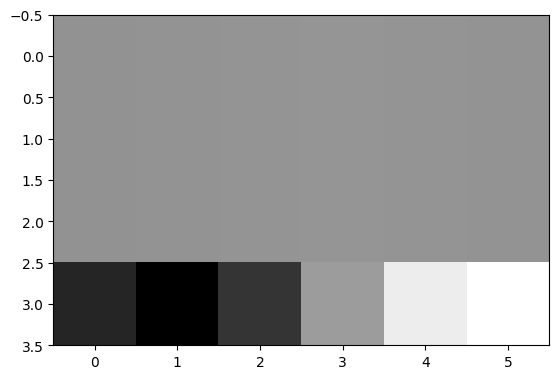

In [151]:
plt.imshow(model.Wff, cmap="Greys");

### Local stimulation

#### Supra-threshold

In [251]:
N = 5
T = 100

x = np.arange(N)
y = np.zeros((T, N))
for t in range(T):
    y[t, np.random.randint(0, N)] = 1

#### Sub-threshold

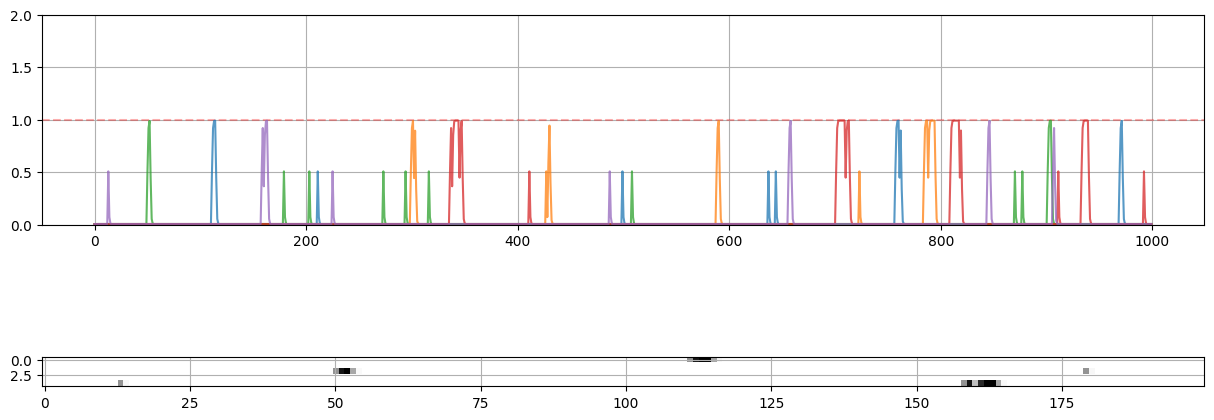

In [1057]:
def subthr(plot=True, noise=True):
    
    T = 1000
    N = 5
    thr = 1.
    u = np.ones((N, 1))*1e-8
    tau_0 = 30.
    tau = tau_0
    curr = np.zeros((N+1, 1))
    
    record = np.zeros((T, N))
    for t in range(T):
    
        p = np.array((u).flatten().tolist() + [1])
        p = p/p.sum()
        curr *= 0
        curr[np.random.choice(range(N+1), p=p, size=1)] = 1.
        u += (-u)/tau + int(noise)*np.random.normal(0., 0.1, (N, 1)) + curr[:-1]
    
        # activation
        u = 1 / (1 + np.exp(-5*(u - thr)))
    
        # adaptive threshold
        #tau += (1*u + tau_0*(1-u) - tau) / 2
        
        # record
        record[t, :] = u.flatten()
    
    if plot:
        plt.figure(figsize=(15, 6))
        plt.subplot(211)
        plt.axhline(thr, linestyle='--', color='red', alpha=0.3)
        for i in range(N):
            plt.plot(range(T), record[:, i], alpha=0.75)
        
        plt.grid()
        plt.ylim((0, 2))

        plt.subplot(212)
        plt.imshow(record[:200].T, cmap='Greys')
        plt.grid()
        plt.show()

    return record

record = subthr(plot=True, noise=0)

**Analysis**

In [1058]:
nb = 100
sum1 = np.zeros((nb, 2))
for i in tqdm(range(nb)):
    rec = subthr(plot=False)
    rec = np.where(rec > 0.4, 1, 0)
    sum1[i] = [rec.sum(axis=1).mean(), 
               (np.exp(rec.sum(axis=0))/np.exp(rec.sum(axis=0)).sum()).std()]

print("With noise")
print(f"mean (over T): {sum1.mean(axis=0)[0]:.3f}")
print(f"std (over N): {sum1.mean(axis=0)[1]:.3f}")

100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.88it/s]

With noise
mean (over T): 0.075
std (over N): 0.367


In [1059]:
nb = 100
sum1 = np.zeros((nb, 2))
for i in tqdm(range(nb)):
    rec = subthr(plot=False, noise=False)
    rec = np.where(rec > 0.4, 1, 0)
    sum1[i] = [rec.sum(axis=1).mean(), 
               (np.exp(rec.sum(axis=0))/np.exp(rec.sum(axis=0)).sum()).std()]

print("Without noise")
print(f"mean (over T): {sum1.mean(axis=0)[0]:.3f}")
print(f"std (over N): {sum1.mean(axis=0)[1]:.3f}")

100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 46.97it/s]

Without noise
mean (over T): 0.070
std (over N): 0.364


In [724]:
sums = []
for i in range(N):
    sums += [np.where(record[:, i] > 0.99, 1, 0).sum()]
print('no noise ', sums, sum(sums))

no noise  [0, 0, 9, 7, 10] 26


In [735]:
sums = []
for i in range(N):
    sums += [np.where(record[:, i] > 0.99, 1, 0).sum()]
print('noise ', sums, sum(sums))

noise  [3, 9, 1, 0, 5] 18


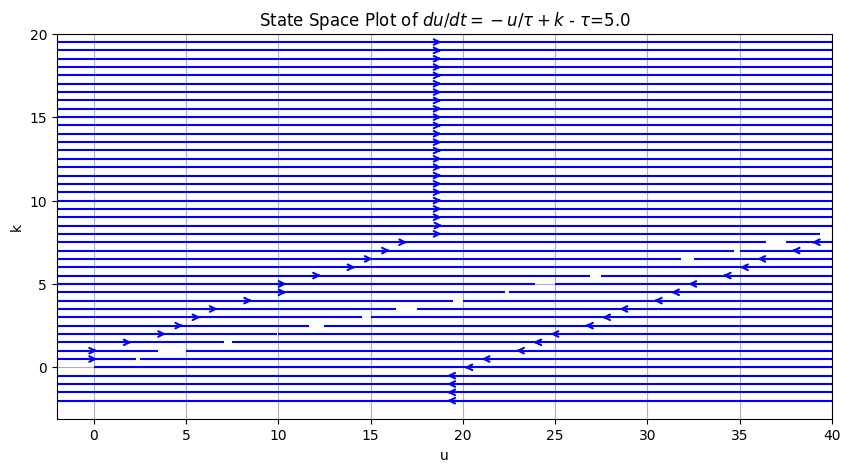

In [284]:
# Parameters
u_range = np.linspace(-2, 40, 40)
k_range = np.linspace(-2, 20, 30)

# Create a grid of u and k values
U, K = np.meshgrid(u_range, k_range)

# Time constant
tau = 5.0

# Define the ODE
dU_dt = -U/tau + K

# Plot
plt.figure(figsize=(10, 5))
plt.streamplot(U, K, dU_dt, np.zeros_like(dU_dt), density=1.5, arrowstyle='->', color='blue')
plt.xlabel('u')
plt.ylabel('k')
plt.title(f"State Space Plot of $du/dt = -u/\\tau + k$ - $\\tau$={tau}")
plt.grid(True)
plt.show()

#### Oscillatory

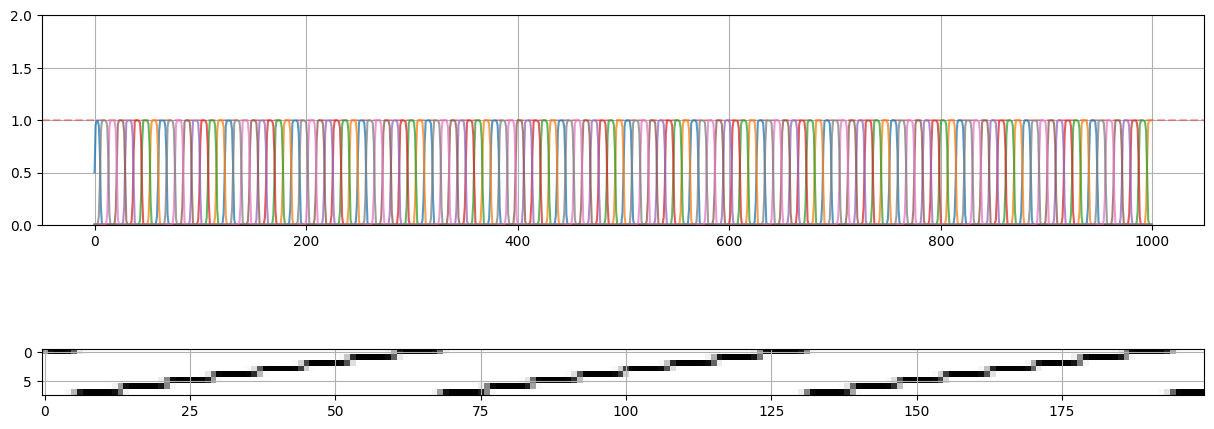

In [8]:
T = 1000
dt = 0.1
N = 8
tuning = np.linspace(0, 2*np.pi, N, endpoint=False).reshape(-1, 1)

thr = 1.
u = np.ones((N, 1))*1e-8
tau_0 = 30.
tau = tau_0
curr = np.zeros((N+1, 1))

record = np.zeros((T, N))
for t in range(T):

    u += (-u)/tau + np.exp(-(np.cos(t*dt + tuning) - 1)**2/0.01)

    # activation
    u = 1 / (1 + np.exp(-6*(u - thr)))

    # adaptive threshold
    #tau += (1*u + tau_0*(1-u) - tau) / 2
    
    # record
    record[t, :] = u.flatten()

plt.figure(figsize=(15, 6))
plt.subplot(211)
plt.axhline(thr, linestyle='--', color='red', alpha=0.3)
for i in range(N):
    plt.plot(range(T), record[:, i], alpha=0.75)

plt.grid()
plt.ylim((0, 2))

plt.subplot(212)
plt.imshow(record[:200].T, cmap='Greys')
plt.grid()
plt.show()


#### + Lateral inhibition

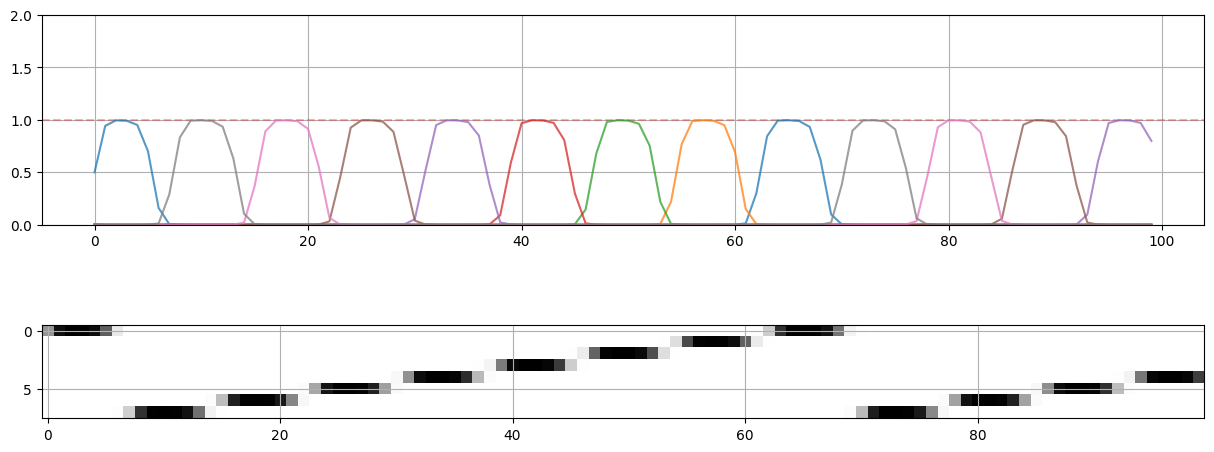

In [69]:
T = 100
dt = 0.1
N = 8
tuning = np.linspace(0, 2*np.pi, N, endpoint=False).reshape(-1, 1)

thr = 1.
u = np.ones((N, 1))*1e-8
tau_0 = 30.
tau = tau_0
curr = np.zeros((N+1, 1))

# lateral
Wr = -1  * (np.ones((N, N)) - np.eye(N))

record = np.zeros((T, N))
for t in range(T):

    u += (-u)/tau + np.exp(-(np.cos(t*dt + tuning) - 1)**2/0.01) + Wr @ u

    # activation
    u = 1 / (1 + np.exp(-6*(u - thr)))

    # adaptive threshold
    #tau += (1*u + tau_0*(1-u) - tau) / 2
    
    # record
    record[t, :] = u.flatten()

plt.figure(figsize=(15, 6))
plt.subplot(211)
plt.axhline(thr, linestyle='--', color='red', alpha=0.3)
for i in range(N):
    plt.plot(range(T), record[:, i], alpha=0.75)

plt.grid()
plt.ylim((0, 2))

plt.subplot(212)
plt.imshow(record[:200].T, cmap='Greys')
plt.grid()
plt.show()


### Plasticity study

#### Only plasticity

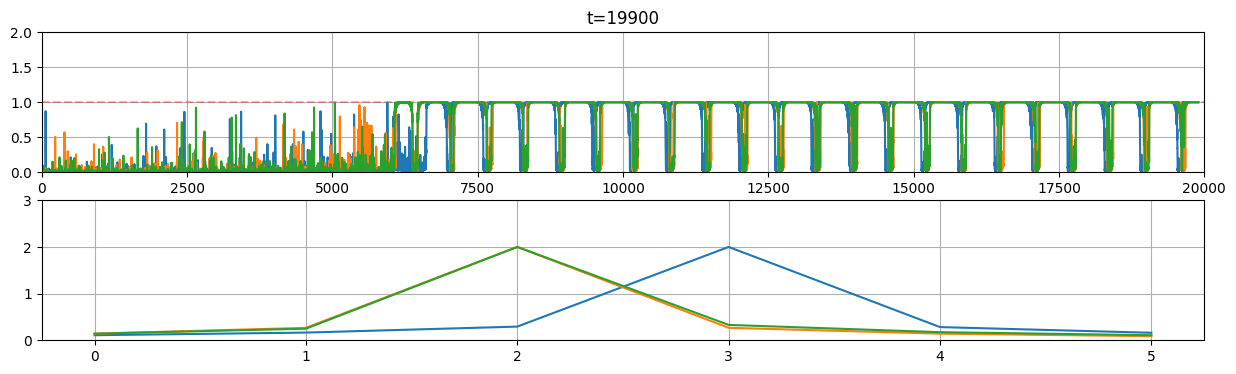

In [59]:
N = 3
T = len(X)

# neural settings
thr = 1.
u = np.ones((N, 1))*1e-8
W = np.ones((N, Nj))*1e-3
tau = 30.
lr = 0.01

# plasticity
rule = 'hebb'
beta = 10

# record
record = np.zeros((T, N))

for t, x in enumerate(X):
        
    u += (-u)/tau + W @ x.reshape(-1, 1) + np.random.normal(0, 0.3, size=(N, 1))**2
    
    # activation
    u = 1 / (1 + np.exp(-6*(u - thr)))

    # plasticity
    if rule == 'hebb':
        dw = u * x
    elif rule == 'oja':
        dw = u * x - W @ (x * x)

    W += lr * dw * (np.exp(beta*W)/np.exp(beta*W).sum(axis=1, keepdims=True))

    W = W.clip(1e-3, 2e0)

    # record
    record[t] = u.flatten()

    if t % 100 == 0:
        clf()
        plt.figure(figsize=(15, 4))
        plt.subplot(211)
        plt.axhline(thr, linestyle='--', color='red', alpha=0.3)
        for i in range(N):
            plt.plot(range(t), record[:t, i])
        plt.ylim((0, 2))
        plt.xlim((0, T))
        plt.grid()
        plt.title(f"{t=}")
        
        plt.subplot(212)
        #plt.imshow(W, cmap='plasma')
        for i in range(N):
            plt.plot(range(Nj), W[i])

        plt.ylim((0, 3))
        plt.grid()
        plt.pause(0.0001)

#### Plasticity + oscillatory local input

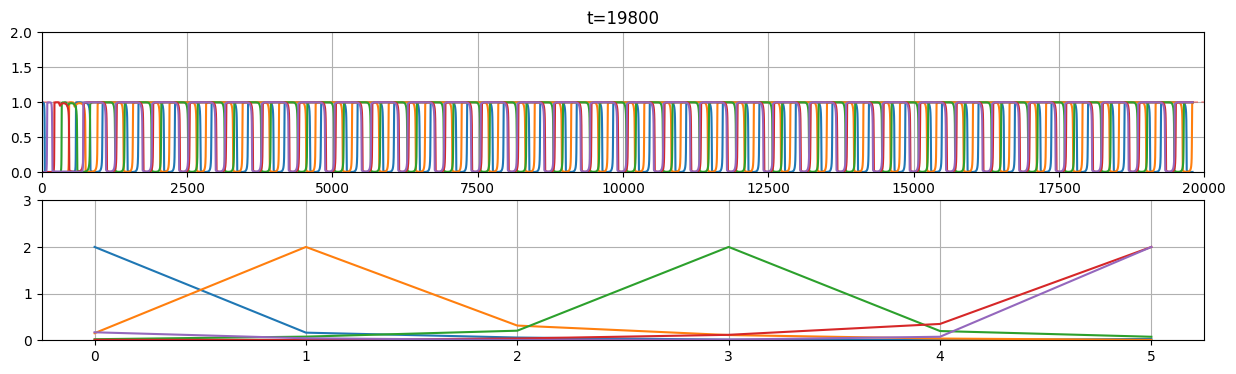

In [60]:
N = 5
T = len(X)

# neural settings
thr = 1.
u = np.ones((N, 1))*1e-8
W = np.ones((N, Nj))*1e-3
tau = 30.
lr = 0.01

# tuning
tuning = np.linspace(0, 2*np.pi, N, endpoint=False).reshape(-1, 1)

# plasticity
rule = 'hebb'
beta = 10

# record
record = np.zeros((T, N))

for t, x in enumerate(X):
        
    u += (-u)/tau + W @ x.reshape(-1, 1) + np.exp(-(np.cos(t*0.01 + tuning) - 1)**2/0.01)
    
    # activation
    u = 1 / (1 + np.exp(-6*(u - thr)))

    # plasticity
    if rule == 'hebb':
        dw = u * x
    elif rule == 'oja':
        dw = u * x - W @ (x * x)

    W += lr * dw * (np.exp(beta*W)/np.exp(beta*W).sum(axis=1, keepdims=True))

    W = W.clip(1e-3, 2e0)

    # record
    record[t] = u.flatten()

    if t % 200 == 0:
        clf()
        plt.figure(figsize=(15, 4))
        plt.subplot(211)
        plt.axhline(thr, linestyle='--', color='red', alpha=0.3)
        for i in range(N):
            plt.plot(range(t), record[:t, i])
        plt.ylim((0, 2))
        plt.xlim((0, T))
        plt.grid()
        plt.title(f"{t=}")
        
        plt.subplot(212)
        #plt.imshow(W, cmap='plasma')
        for i in range(N):
            plt.plot(range(Nj), W[i])

        plt.ylim((0, 3))
        plt.grid()
        plt.pause(0.0001)

#### Lateral inhibition

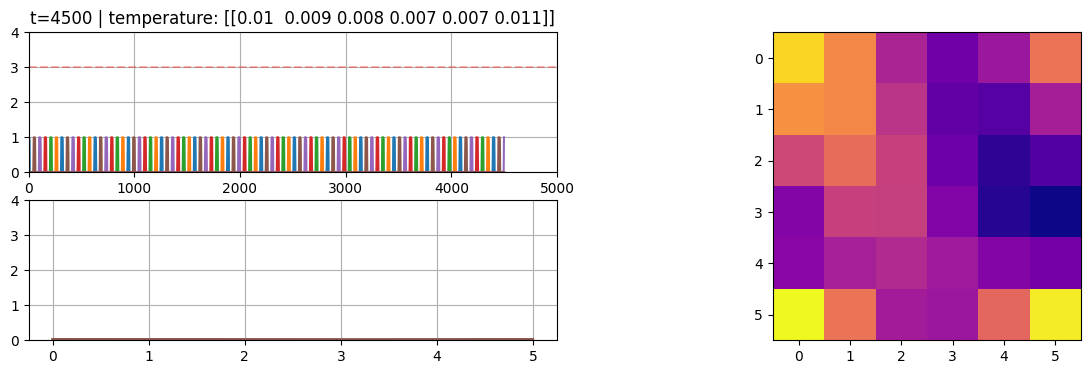

In [211]:
N = 6
T = len(X)

# neural settings
thr = 3.
u = np.ones((N, 1))*1e-8
W = np.ones((N, Nj))*1e-3
wmax = 3
tau_0 = 20.
tau = tau_0
lr = 0.01

# tuning
tuning_0 = np.linspace(0, 2*np.pi, N, endpoint=False).reshape(-1, 1)
tuning = tuning_0.copy()

# plasticity
rule = 'hebb'
beta = 10
temp = np.zeros((N, 1))

# lateral inhibition
Wr = -1 * (np.ones((N, N)) - np.eye(N))

# record
record = np.zeros((T, N))

for t, x in enumerate(X):
        
    u += (-u)/tau + W @ x.reshape(-1, 1) + thr * (1 - temp) * np.exp(
        - (np.cos(t*0.02 + tuning) - 1)**2/0.001) + Wr @ u #+ np.random.normal(0, 0.2, (N, 1))**2
    
    # activation
    u = 1 / (1 + np.exp(-7*(u - thr)))

    # time constant
    #tau += (1*u + tau_0*(1-u) - tau) / 2

    # temperature
    temp = (W.max(axis=1) / wmax).reshape(-1, 1)

    # weight decay
    W += (- W / 500) * (1 - temp)

    # plasticity
    if rule == 'hebb':
        dw = u * x
    elif rule == 'oja':
        dw = u * x - W @ (x * x)

    W += lr * dw * (np.exp(beta*W)/np.exp(beta*W).sum(axis=1, keepdims=True))

    W = W.clip(0., wmax)

    # record
    record[t] = u.flatten()

    if t % 500 == 0:
        clf()
        plt.figure(figsize=(15, 4))
        plt.subplot(221)
        plt.axhline(thr, linestyle='--', color='red', alpha=0.3)
        for i in range(N):
            plt.plot(range(t), record[:t, i])
        plt.ylim((0, thr+1))
        plt.xlim((0, T))
        plt.grid()
        plt.title(f"{t=} | temperature: {np.around(temp.T, 3)}")
        
        plt.subplot(223)
        #plt.imshow(W, cmap='plasma')
        for i in range(N):
            plt.plot(range(Nj), W[i])

        plt.ylim((0, wmax+1))
        plt.grid()

        plt.subplot(122)
        plt.imshow(W, cmap='plasma')
        plt.pause(0.0001)

## Simulation II

**Load individual**

In [1152]:
file = me.load_best_individual()
info, genome = file['info'], file['genome']

2023-11-30 17:31:04 | Available files in /Users/daniekru/Research/lab/PCNN/cache:
2023-11-30 17:31:04 | 0: top_2311.json
2023-11-30 17:31:04 | 1: best_3011_1604.json
2023-11-30 17:31:04 | 2: top_2238.json
2023-11-30 17:31:04 | 3: top_ij_1.json
2023-11-30 17:31:04 | 4: best_3011_1527.json
2023-11-30 17:31:04 | 5: best_3011_1545.json
2023-11-30 17:31:04 | 6: top_2239_r3.json
2023-11-30 17:31:04 | 7: best_3011_1641.json
2023-11-30 17:31:04 | 8: best_3011_1552.json
2023-11-30 17:31:04 | 9: best_3011_1554.json
2023-11-30 17:31:04 | 10: best_3011_1558.json


Choose a file:  7


2023-11-30 17:31:08 | Best individual loaded from best_3011_1641.json in /Users/daniekru/Research/lab/PCNN/cache.


In [1153]:
print('Info')
pprint(info)
print('\nGenome')
pprint(genome)

model = mm.RateNetwork3(**genome)
logger.info(model)

2023-11-30 17:31:10 | RateNetwork3(N=15, Nj=6, rule=hebb) [C8gcD]


Info
{'date': '30/11/2023 at 16:41',
 'game': 'Track2D(Nj=6, fitness_size=1)',
 'model': 'RateNetwork3'}

Genome
{'N': 15,
 'Nj': 6,
 'bias': 3.0,
 'dt': 0.04,
 'gain': 9.0,
 'lr': 0.99176,
 'rule': 'hebb',
 'soft_beta': 95.0,
 'std_tuning': 0.0003,
 'tau': 93,
 'wff_max': 3.0,
 'wff_min': 0.0,
 'wff_std': 0.001,
 'wff_tau': 11}


**Tweak the model**

In [1166]:
genome['N'] = 25
genome['Nj'] = 10

model = mm.RateNetwork3(**genome)
logger.info(model)

2023-11-30 17:32:21 | RateNetwork3(N=25, Nj=10, rule=hebb) [SvQxE]


**Settings**

2023-11-30 17:32:22 | InputLayer(N=10, kind=hd, sigma=1)


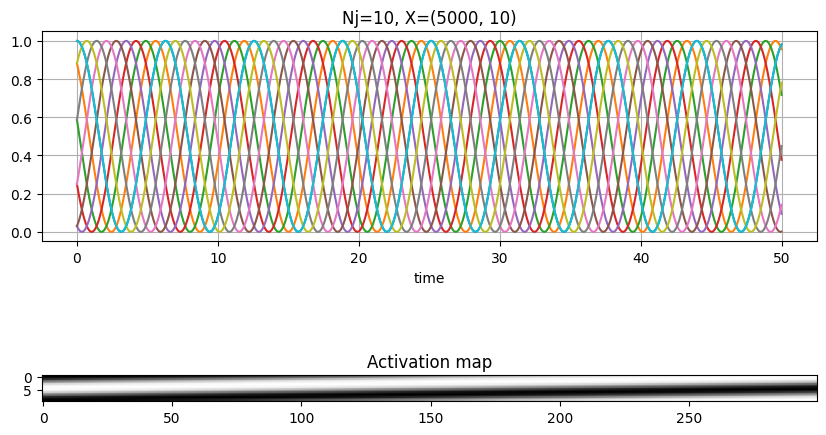

In [1167]:
N = model.N
Nj = model.Nj

# data
layer = it.InputLayer(N=Nj, kind='hd', sigma=1, max_rate=1)
logger.info(layer)

# input
X = layer.parse_trajectory(np.arange(0, 50, 0.01))
T = len(X)

# plot
plot_x(X)

**Training**

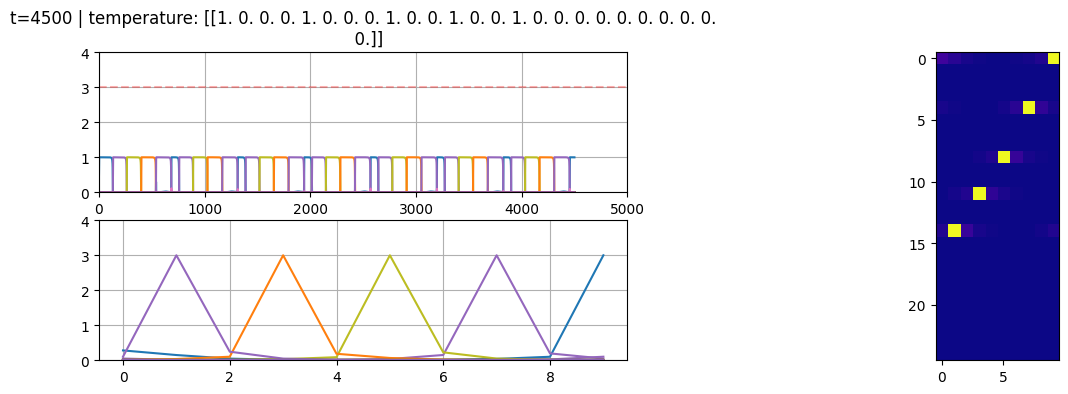

In [1168]:
model.reset()

# record
record = np.zeros((T, N))

for t, x in enumerate(X):
        
    model.step(x=x.reshape(-1, 1))

    # record
    record[t] = model.u.flatten()

    if t % 500 == 0:
        clf()
        plt.figure(figsize=(15, 4))
        plt.subplot(221)
        plt.axhline(model._bias, linestyle='--', color='red', alpha=0.3)
        for i in range(N):
            plt.plot(range(t), record[:t, i])
        plt.ylim((0, model._bias+1))
        plt.xlim((0, T))
        plt.grid()
        plt.title(f"{t=} | temperature: {np.around(model.temp.T, 3)}")
        
        plt.subplot(223)
        #plt.imshow(W, cmap='plasma')
        for i in range(N):
            plt.plot(range(Nj), model.Wff[i])

        plt.ylim((0, model._wff_max+1))
        plt.grid()

        plt.subplot(122)
        plt.imshow(model.Wff, cmap='plasma')
        plt.pause(0.0001)

In [982]:
W = model.Wff.copy()
W

array([[3.00000000e+00, 3.00000000e+00, 3.00000000e+00, 3.00000000e+00,
        3.00000000e+00, 3.00000000e+00],
       [2.30371599e-11, 2.36826151e-11, 9.45268054e-12, 1.26421132e-14,
        8.40831208e-12, 2.30371599e-11],
       [3.80919115e-12, 4.45628723e-12, 2.14323454e-12, 6.65932836e-14,
        1.09621109e-12, 3.80919115e-12],
       [6.13050770e-13, 8.18969297e-13, 4.64183565e-13, 3.89953961e-14,
        1.31000388e-13, 6.13050770e-13],
       [9.64450906e-14, 1.48100158e-13, 9.74256121e-14, 1.44519535e-14,
        1.38459579e-14, 9.64450906e-14],
       [5.14240177e-10, 4.09566623e-10, 1.01383997e-10, 1.55902144e-11,
        2.70749366e-10, 5.14240177e-10]])

In [994]:
# only one top value per row
sorted_rows = np.sort(W, axis=1)
print(np.around(sorted_rows, 3))
value_2 = sorted_rows[:, -1:].sum() - sorted_rows[:, :-1].sum()
print(sorted_rows[:, -1:].sum(), sorted_rows[:, :-1].sum())

[[3. 3. 3. 3. 3. 3.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
3.0000000005433463 15.000000001388582


In [996]:
W.sum(axis=1)

array([1.80000000e+01, 8.76305697e-11, 1.53807084e-11, 2.67925019e-12,
       4.66713862e-13, 1.82577055e-09])

In [992]:
# only one top value per column
sorted_cols = np.sort(W, axis=0)
print(np.around(sorted_cols, 3))
value_1 = sorted_cols[-1:, :].sum() - sorted_cols[:-1, :].sum()
print(sorted_cols[-1:, :].sum(), sorted_cols[:-1, :].sum())

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [3. 3. 3. 3. 3. 3.]]
18.0 1.931927795904259e-09


In [1006]:
-((W.sum(axis=1) - 3.)**2).sum()

-269.99999998840843

In [1059]:
import numpy as np

# Example usage
matrix = np.array([
    [0, 1, 0],
    [1, 0, 0],
    [0, 1, 0]
])

n = matrix.shape[0]
sorted_matrix = np.zeros_like(matrix)
max_indices = np.argmax(matrix, axis=1)

for row in range(n):
    sorted_matrix[row, row] = matrix[row, max_indices[row]]

print(sorted_matrix)


[[1 0 0]
 [0 1 0]
 [0 0 1]]


In [1109]:
W = model.Wff.copy()
np.around(W, 2)

array([[2.5 , 0.05, 0.01, 0.01, 0.06, 0.22],
       [0.01, 0.  , 0.04, 2.5 , 0.11, 0.01],
       [0.01, 0.  , 0.04, 2.5 , 0.1 , 0.01],
       [0.01, 0.  , 0.03, 2.5 , 0.09, 0.01],
       [0.04, 2.5 , 0.09, 0.01, 0.  , 0.04],
       [0.01, 0.  , 0.04, 2.5 , 0.1 , 0.01],
       [0.01, 0.  , 0.03, 2.5 , 0.09, 0.01],
       [0.06, 2.5 , 0.06, 0.  , 0.01, 0.06],
       [0.01, 0.06, 2.5 , 0.06, 0.01, 0.  ],
       [0.06, 0.  , 0.01, 0.06, 2.5 , 0.06]])

In [1116]:
I, J = W.shape
sorted_matrix = np.zeros_like(W)
max_indices = np.argmax(W, axis=1)

for i in range(I):
    sorted_matrix[i, min((i, J-1))] = W[i, max_indices[i]]
        
target = 3. * np.eye(I)[:, :J]
value_3 = -((sorted_matrix - target)**2).sum() / (I*J)


In [1111]:
target

array([[3., 0., 0., 0., 0., 0.],
       [0., 3., 0., 0., 0., 0.],
       [0., 0., 3., 0., 0., 0.],
       [0., 0., 0., 3., 0., 0.],
       [0., 0., 0., 0., 3., 0.],
       [0., 0., 0., 0., 0., 3.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [1113]:
sorted_matrix

array([[2.5, 0. , 0. , 0. , 0. , 0. ],
       [0. , 2.5, 0. , 0. , 0. , 0. ],
       [0. , 0. , 2.5, 0. , 0. , 0. ],
       [0. , 0. , 0. , 2.5, 0. , 0. ],
       [0. , 0. , 0. , 0. , 2.5, 0. ],
       [0. , 0. , 0. , 0. , 0. , 2.5],
       [0. , 0. , 0. , 0. , 0. , 2.5],
       [0. , 0. , 0. , 0. , 0. , 2.5],
       [0. , 0. , 0. , 0. , 0. , 2.5],
       [0. , 0. , 0. , 0. , 0. , 2.5]])

In [1114]:
value_3

-0.44166666666666665